In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('data_hpo-method-validation_2023-01-30_14-43.csv', encoding="utf_16_le", delimiter=";")

column_descriptions = df.loc[0]

# Quick Info

<Axes: >

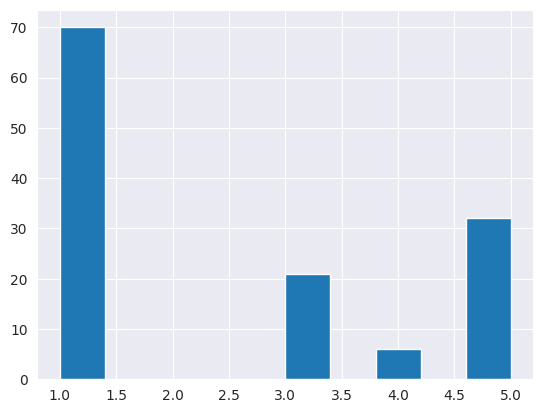

In [3]:
#visualize completed pages
maxpage = df["MAXPAGE"]
maxpage.iloc[1:].apply(pd.to_numeric).hist()

# Auswertung Goals & Methods

In [4]:
#select only finished data set complete datasets
df_finished = df.where(
    (df["FINISHED"] == "1") | (df["FINISHED"] == "Wurde die Befragung abgeschlossen (letzte Seite erreicht)?")).dropna(
    subset=["FINISHED"])

In [5]:
# select only answers relating to the first question (Which of the following goals did you try to reach by using HPO?)
df_go01 = df_finished.filter(regex=("^GO01"))

# select only answers relating to the second question (Which of the following goals did you successfully attain by using HPO?)
df_go02 = df_finished.filter(regex=("^GO02"))

In [6]:
df_go01.head()

,GO01_01_CN,GO01_01_1,GO01_01_2,GO01_01_3,GO01_01_4,GO01_01_5,GO01_02_CN,GO01_02_1,GO01_02_2,GO01_02_3,...,GO01_05_2,GO01_05_3,GO01_05_4,GO01_05_5,GO01_06_CN,GO01_06_1,GO01_06_2,GO01_06_3,GO01_06_4,GO01_06_5
0,Goal-Method Selection: Anzahl ausgewählter Opt...,Goal-Method Selection: Decrease Necessary Comp...,Goal-Method Selection: Decrease Necessary Comp...,Goal-Method Selection: Decrease Necessary Comp...,Goal-Method Selection: Decrease Necessary Comp...,Goal-Method Selection: Decrease Necessary Comp...,Goal-Method Selection: Anzahl ausgewählter Opt...,Goal-Method Selection: Decrease Practitioner E...,Goal-Method Selection: Decrease Practitioner E...,Goal-Method Selection: Decrease Practitioner E...,...,Goal-Method Selection: Satisfy Requirements:Yo...,Goal-Method Selection: Satisfy Requirements:Yo...,Goal-Method Selection: Satisfy Requirements:Yo...,Goal-Method Selection: Satisfy Requirements:Yo...,Goal-Method Selection: Anzahl ausgewählter Opt...,Goal-Method Selection: Target Audience Complia...,Goal-Method Selection: Target Audience Complia...,Goal-Method Selection: Target Audience Complia...,Goal-Method Selection: Target Audience Complia...,Goal-Method Selection: Target Audience Complia...
2,1,nicht gewählt,nicht gewählt,nicht gewählt,ausgewählt,nicht gewählt,1,ausgewählt,nicht gewählt,nicht gewählt,...,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,1,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt
5,1,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,1,ausgewählt,nicht gewählt,nicht gewählt,...,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,1,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt
14,I did not try to reach this goal.,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,I did not try to reach this goal.,nicht gewählt,nicht gewählt,nicht gewählt,...,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,I did not try to reach this goal.,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt,nicht gewählt
16,1,nicht gewählt,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt,2,nicht gewählt,ausgewählt,nicht gewählt,...,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt,1,nicht gewählt,ausgewählt,nicht gewählt,nicht gewählt,nicht gewählt


## Gesamt Heatmap

In [62]:
# define method to create heatmap counting all occurences of method combinations

def create_2d_matrix(df):
    heatmap = []

    replacement = {
        "Another HPO Method": "Advanced HPO",
        "Bayesian Optimization": "Advanced HPO",
        "Grid Search": "Simple HPO",
        "Random Search": "Simple HPO"
    }

    for index, column in enumerate(df.columns):

        row = {}

        #extract the method
        item_description = df[column][0]
        method = re.findall("([^/]+$)", item_description)[0]
        goal = re.findall(":\s(.*):", item_description)[0]

        # Aggregate
        method = replacement.get(method, method)


        count = df[column].str.contains(r'ausgewählt').sum()

        if index % 6 == 0:
            method = "I did not try to reach the goal"
            goal = re.search(":\s(.*):\s(.*):", item_description)
            goal = goal.group(2)
            count = df[column].str.contains(r'I did not try to reach this goal.').sum()

        row = {"method": method, "goal": goal, "count": count}

        heatmap.append(row)

    df_heatmap = pd.DataFrame(heatmap)

    # Aggregate
    df_heatmap = df_heatmap.groupby(["method", "goal"]).sum().reset_index()

    return df_heatmap.pivot(index='method', columns='goal', values='count')


In [63]:
create_2d_matrix(df_go01)

goal,Decrease Necessary Computations,Decrease Practitioner Effort,Increase Model Comprehension,Increase Model Performance,Satisfy Requirements,Target Audience Compliance
method,,,,,,
Advanced HPO,11,10,7,12,7,7
I did not try to reach the goal,8,8,8,0,13,15
Manual Tuning,10,8,13,17,9,3
Simple HPO,7,18,6,26,5,7


### Try

<Axes: xlabel='goal', ylabel='method'>

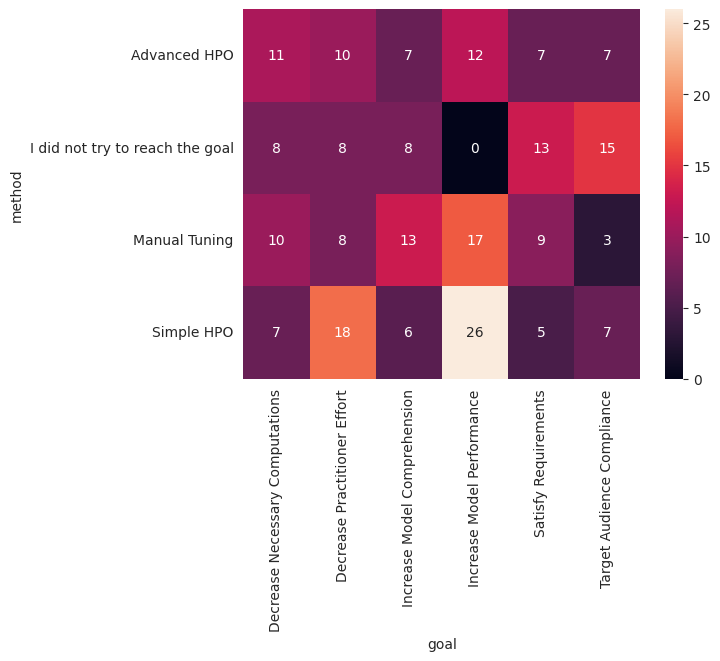

In [64]:
sns.heatmap(create_2d_matrix(df_go01), annot=True)

### Successful

<Axes: xlabel='goal', ylabel='method'>

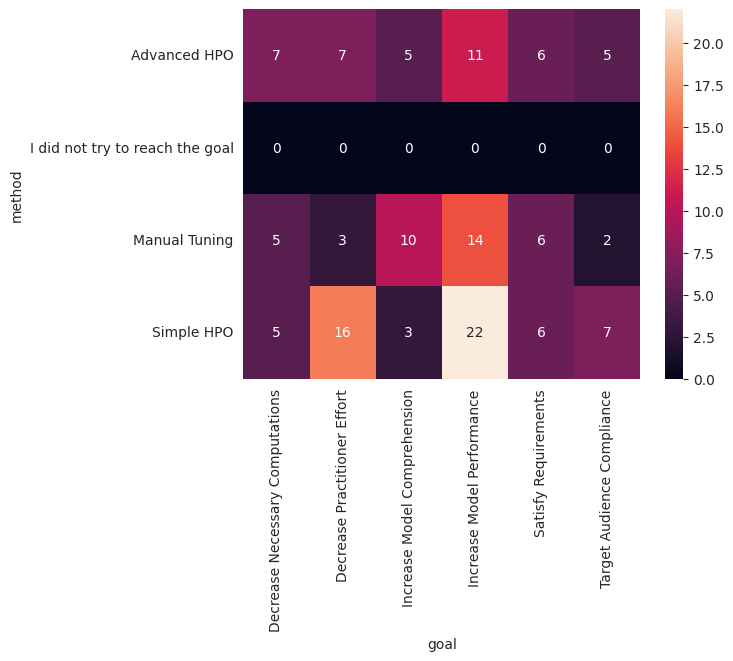

In [65]:
sns.heatmap(create_2d_matrix(df_go02), annot=True)

# Correcting implausible answers

In [66]:
heatmap_pivot = create_2d_matrix(df_go01)
heatmap_pivot_successful = create_2d_matrix(df_go02)

In [67]:
tried = df_go01.where(df_go01 == "ausgewählt").replace({'ausgewählt': 1})
tried = tried.fillna(0)
success = df_go02.where(df_go02 == "ausgewählt").replace({'ausgewählt': 1})
success = success.fillna(0)

In [68]:
#check for unplausible results in which successful is selected but tried is not
res = (tried - success.values)
is_negative = (res < 0).any(axis=1)


In [69]:
df_go01_clean = df_go01.drop(is_negative[is_negative == True].index)
df_go02_clean = df_go02.drop(is_negative[is_negative == True].index)

<Axes: title={'center': 'Percentage of self perceived successfully attained Goal'}, xlabel='method'>

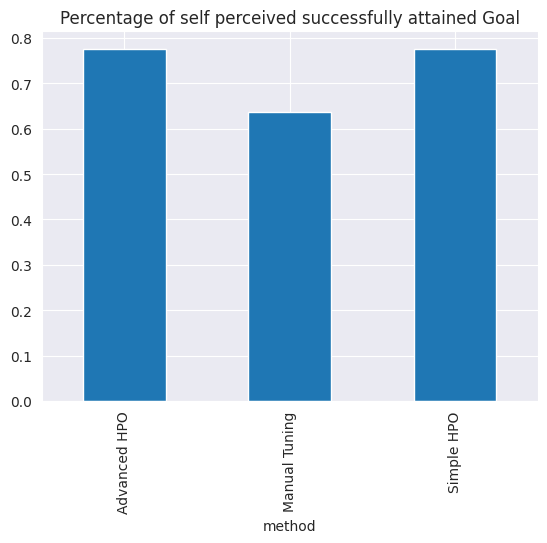

In [70]:
(create_2d_matrix(df_go02_clean).sum(axis=1) / create_2d_matrix(df_go01_clean).sum(axis=1)).drop(
    'I did not try to reach the goal').plot(kind='bar', title='Percentage of self perceived successfully attained Goal')

<Axes: xlabel='method'>

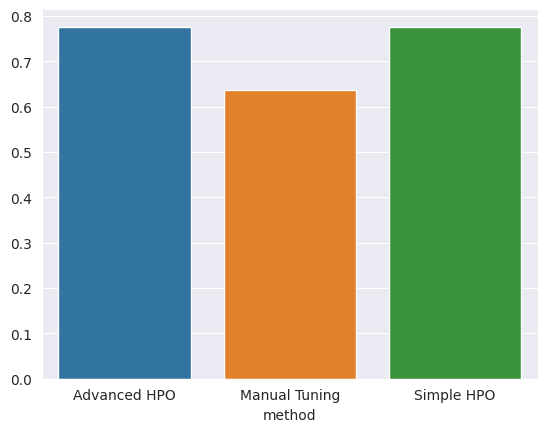

In [71]:
seaborn_success = (create_2d_matrix(df_go02_clean).sum(axis=1) / create_2d_matrix(df_go01_clean).sum(axis=1)).drop(
    'I did not try to reach the goal').copy()
sns.barplot(y=seaborn_success.values, x=seaborn_success.index)

<Axes: xlabel='goal', ylabel='method'>

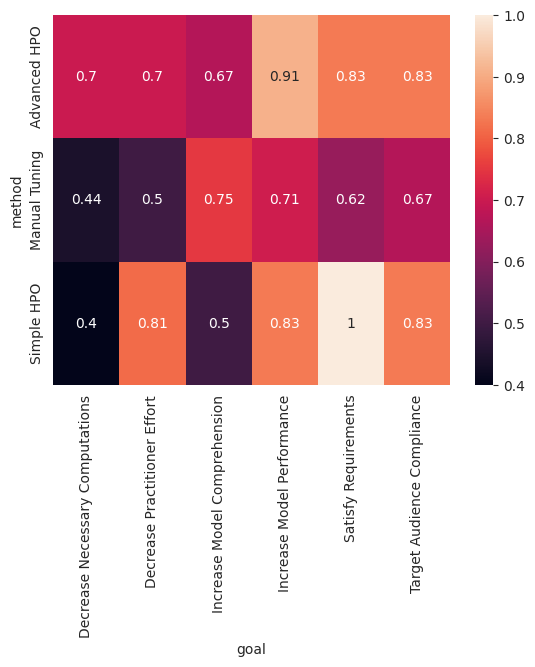

In [72]:
#Successrate filtered
sns.heatmap(
    ((create_2d_matrix(df_go02_clean)) / (create_2d_matrix(df_go01_clean))).drop('I did not try to reach the goal'),
    annot=True)

<Axes: xlabel='goal', ylabel='method'>

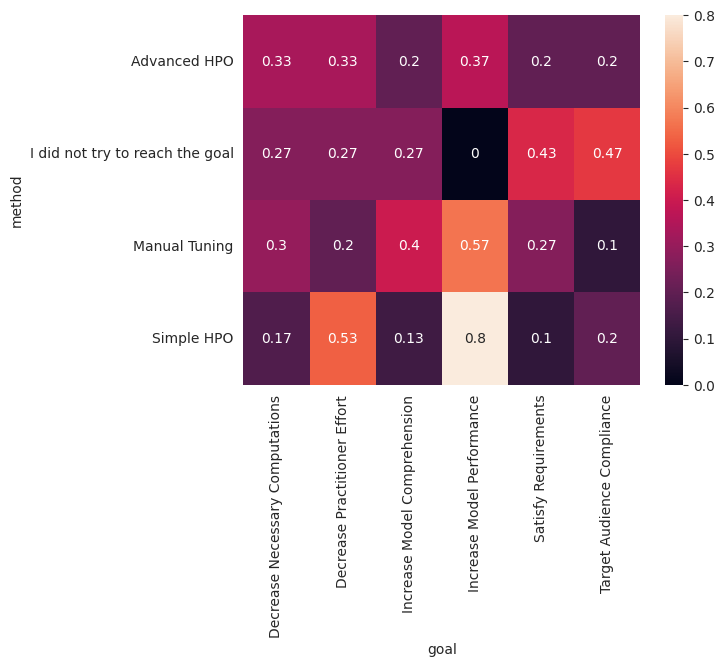

In [73]:
sns.heatmap(create_2d_matrix(df_go01_clean) / df_go01_clean.shape[0], annot=True)

<Axes: xlabel='goal', ylabel='method'>

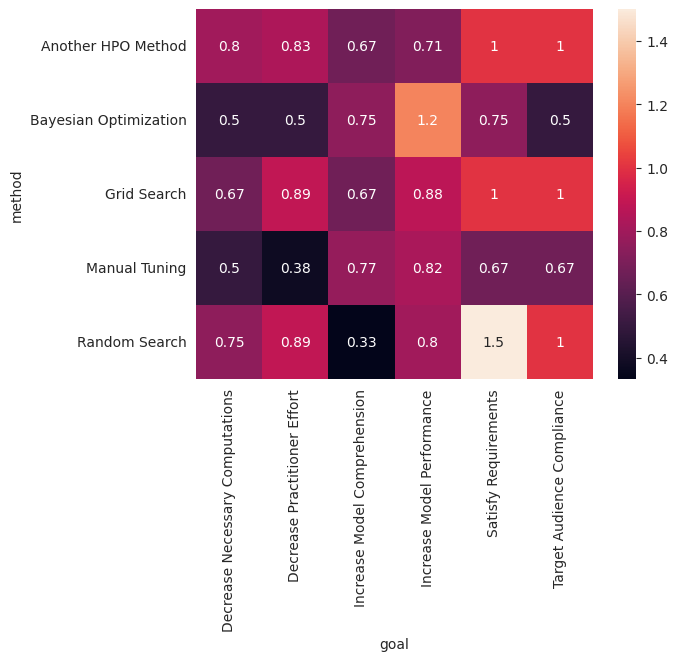

In [34]:
#Successrate unfiltered
sns.heatmap(((create_2d_matrix(df_go02)) / (create_2d_matrix(df_go01))).drop('I did not try to reach the goal'),
            annot=True)